# Problem statement: 
   The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. Please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
* Dataset is imbalanced. The data has 41188 rows and 20 variables.
* This is a classification problem. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


# Workflow:
- Load the dataset
- Basic data processing

## 1) Local mode training, by using a subset of large dataset

## 2) Training on SageMaker Cloud:
   - Prepare data for SageMaker cloud training:
       - Convert data to .csv and .recordio types
       - Upload training and validation datasets to S3 bucket
       
   - Specify training algorithm Docker Image
   - Build the XGBoost model
   - Specify training data location and optionally, validation data location
   - Train the model on SageMaker cloud
   - Deploy the model, and run real-time predictions
   - Evaluate the model (by auc score, confusion matrix, f1 score, roc curve, etc.)   



In [1]:
# Istall XGBoost package and update numpy (for the local mode):
!conda install -y -c conda-forge xgboost
!conda update -y numpy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    numpy-1.14.3               |   py36h28100ab_1          41 KB
    xgboost-0.72.1             |   py36hfc679d8_1         1.6 MB  conda-forge
    certifi-2018.8.24          |           py36_1         139 KB  conda-forge
    openssl-1.0.2p             |       h470a237_0         3.5 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following NEW package

In [2]:
import sklearn
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [3]:
df=pd.read_csv('bankMarketing_All.csv', sep = ';')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

# Data Preparation/Cleaning:

In [4]:
L_cat=['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
       'contact', 'month', 'day_of_week']
L_con=['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


encode_text_index(df, 'y')

for c in L_cat:
    encode_text_index(df, c)
    
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [7]:
X=df.drop(['y'], axis=1)
y=df['y']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [8]:
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1) 

In [9]:
# Write to SageMaker Notebook Instance: It is saved in the folder where this ipynb was created

df_train.to_csv('bankMarketing_train.csv', index=False, header=False)
df_test.to_csv('bankMarketing_test.csv', index=False, header=False)

#  1) Local Mode Training (usually on a subset of large dataset): 

In [11]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

hyper_params={'gamma': 0, 
              'max_depth': 6, 
              'min_child_weight': 10, 
              'subsample': 0.7}

model=XGBClassifier(**hyper_params, missing=999, scale_pos_weight=36548/4640, seed=42) 
kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.94958122 0.94545511 0.94501575] 

Accuracy: 0.95 (+/- 0.00)


# 2)  Training on SageMaker Cloud

# preparing data for SageMaker cloud training: 
    - Converting data to .csv or .recodio types
    - Uploading training & validation datasets to S3 bucket

In [12]:
# Specify the Keys and Location of Train & Test datasets in S3:
bucket_name = 'roohi-ml-sagemaker'
training_file_key = 'bankMarketing/bankMarketing_train.csv'
test_file_key = 'bankMarketing/bankMarketing_test.csv'

s3_model_output_location = r's3://{0}/bankMarketing/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_file_key)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_file_key)

In [13]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3. File name is referred as key name in S3.
# Files stored in S3 are automatically replicated across 3 different availability zones in the region where the bucket was created.
# http://boto3.readthedocs.io/en/latest/guide/s3.html

def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [14]:
write_to_s3('bankMarketing_train.csv', bucket_name, training_file_key)
write_to_s3('bankMarketing_test.csv', bucket_name, test_file_key)

   # Training Algorithm Docker Image:  
    Note: AWS Maintains a separate image for every region and algorithm

In [15]:
# Registry Path for algorithms provided by SageMaker
#  https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [16]:
role = get_execution_role()

# This role contains the permissions needed to train, deploy models
# SageMaker Service is trusted to assume this role
print(role)

arn:aws:iam::928921801380:role/service-role/AmazonSageMaker-ExecutionRole-20180831T120207


# Build model: 

In [33]:
sess = sagemaker.Session()

In [37]:
# Access appropriate algorithm container image
#  Specify how many instances to use for distributed training and what type of machine to use
#  Finally, specify where the trained model artifacts needs to be stored
#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html
#    Optionally, give a name to the training job using base_job_name

estimator = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role,
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=s3_model_output_location,
                                       sagemaker_session=sess,
                                       base_job_name ='xgboost-bankMarketing-Train')

In [40]:
# Specify hyper parameters that appropriate for the training algorithm
# Take a look this table for metrics & parameters:   https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

classRatio=df_train['y'].value_counts()[0]/df_train['y'].value_counts()[1]

hyper_params={'gamma': 0, 
              'max_depth': 6, 
              'min_child_weight': 10, 
              'subsample': 0.7,
              'eval_metric':'auc',          
              'objective':'binary:logistic',    
              'missing':999, 
              'scale_pos_weight':classRatio, 
              'seed':42, 
              'num_round':100}

estimator.set_hyperparameters(**hyper_params)

estimator.hyperparameters()

{'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 10,
 'subsample': 0.7,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'missing': 999,
 'scale_pos_weight': 7.876539408866995,
 'seed': 42,
 'num_round': 100}

#    Specify Training Data Location and Optionally, Validation Data Location:

In [41]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(s3_data=s3_training_file_location, content_type="csv")
test_input_config = sagemaker.session.s3_input(s3_data=s3_test_file_location, content_type="csv")

print(training_input_config.config)
print(test_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/bankMarketing/bankMarketing_train.csv'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/bankMarketing/bankMarketing_test.csv'}}, 'ContentType': 'csv'}


# Train the model on SM cloud:

In [42]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm    
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

estimator.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating training-job with name: xgboost-bankMarketing-Train-2018-09-03-04-59-38-732


....................
Arguments: train
[2018-09-03:05:02:49:INFO] Running standalone xgboost training.
[2018-09-03:05:02:49:INFO] File size need to be processed in the node: 2.85mb. Available memory size in the node: 8606.85mb
[2018-09-03:05:02:49:INFO] Determined delimiter of CSV input is ','
[05:02:49] S3DistributionType set as FullyReplicated
[05:02:49] 28831x20 matrix with 576620 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-03:05:02:49:INFO] Determined delimiter of CSV input is ','
[05:02:49] S3DistributionType set as FullyReplicated
[05:02:49] 12357x20 matrix with 247140 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[05:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]#011train-auc:0.942132#011validation-auc:0.941644
[05:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[1]#


Billable seconds: 92


## Deploy Model & Run Real-time Predictions:

In [43]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-bankMarketing-Train')

INFO:sagemaker:Creating model with name: xgboost-2018-09-03-05-03-20-910
INFO:sagemaker:Creating endpoint with name xgboost-bankMarketing-Train


---------------------------------------------------------------!

In [44]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [45]:
df_test = pd.read_csv('bankMarketing_test.csv', header=None)

X_test=df_test.loc[0:, 1:].as_matrix()
y_test=df_test.loc[0:, 0].as_matrix()

In [46]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
probability = []
for arr in np.array_split(X_test,10):
    result = predictor.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    probability += [float(r) for r in result]
    
predictions=[0 if p<0.5 else 1 for p in probability]

(1236, 20)
(1236, 20)
(1236, 20)
(1236, 20)
(1236, 20)
(1236, 20)
(1236, 20)
(1235, 20)
(1235, 20)
(1235, 20)


# Evaluate the initial model:

In [47]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

report=classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.98      0.89      0.93     10965
          1       0.49      0.87      0.63      1392

avg / total       0.93      0.88      0.90     12357



Confusion matrix, without normalization
[[9724 1241]
 [ 187 1205]]
Normalized confusion matrix
[[0.89 0.11]
 [0.13 0.87]]


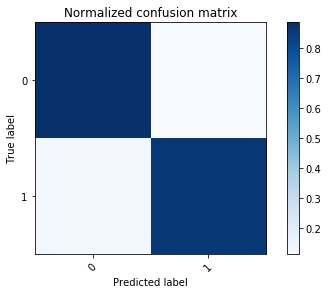

In [48]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

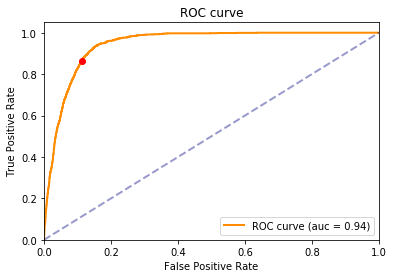

In [49]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), probability, pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), probability)

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

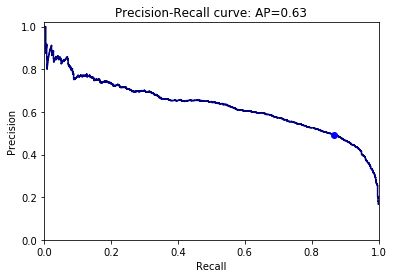

In [50]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test, probability,  pos_label=1)
ave_precision=average_precision_score(y_test, probability)

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()

In [55]:
# boto3.Session().client('sagemaker').delete_endpoint(EndpointName='xgboost-bikeRental-Optimized')